In [21]:
%matplotlib inline

import sys
sys.path.append("../")
import scvi
from smFISHxscRNA.dataset import CortexDataset, SmfishDataset
from smFISHxscRNA.inference import VariationalInferenceFish
from smFISHxscRNA.models import VAEF
from smFISHxscRNA.metrics.clustering import get_data, get_common_t_sne, entropy_batch_mixing
from smFISHxscRNA.metrics.visualisation import show_cell_types, show_mixing, compare_cell_types, show_gene_exp, show_spatial_expression
from smFISHxscRNA.metrics.classification import cluster_accuracy_nn
from smFISHxscRNA.metrics.imputation import plot_correlation, proximity_imputation, compute_metrics, get_index
import numpy as np
from smFISHxscRNA.train import train_FISHVAE_jointly


In [2]:
genes_to_discard = ['gad2']
gene_dataset_fish = SmfishDataset()
gene_names = gene_dataset_fish.gene_names
l = []
for n_gene in range(len(gene_names)):
    for gene in genes_to_discard:
        if gene_names[n_gene].lower() == gene.lower():
            l.append(n_gene)
genes_to_discard = l
# The "genes_to_discard" argument is given here so that the order of the genes in CortexDataset matches
# the order in SmfishDataset

File data/osmFISH_SScortex_mouse_all_cell.loom already downloaded
Preprocessing smFISH dataset
Finished preprocessing smFISH dataset


In [3]:
gene_dataset_seq = CortexDataset(genes_fish=gene_dataset_fish.gene_names, genes_to_discard=genes_to_discard,
                                 genes_to_keep=["mog", "sst", "gja1"], additional_genes=70)

File data/expression.bin already downloaded
Preprocessing Cortex data
Finished preprocessing Cortex data


In [4]:
# Creating dataloaders
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
use_cuda = False
gene_dataset = gene_dataset_seq
tt_split =0.9
example_indices = np.random.permutation(len(gene_dataset))
tt_split = int(tt_split * len(gene_dataset))  # 90%/10% train/test split
data_loader_seq = DataLoader(gene_dataset, batch_size=128, pin_memory=use_cuda,
                               sampler=SubsetRandomSampler(example_indices[:tt_split]),
                               collate_fn=gene_dataset.collate_fn)


gene_dataset = gene_dataset_fish
tt_split =0.9
example_indices = np.random.permutation(len(gene_dataset))
tt_split = int(tt_split * len(gene_dataset))  # 90%/10% train/test split
data_loader_fish = DataLoader(gene_dataset, batch_size=128, pin_memory=use_cuda,
                               sampler=SubsetRandomSampler(example_indices[:tt_split]),
                               collate_fn=gene_dataset.collate_fn)

In [5]:
vae = VAEF(gene_dataset_seq.nb_genes, gene_dataset_fish.nb_genes, genes_to_discard=genes_to_discard, n_latent=8,
           n_layers=2, n_hidden=256, reconstruction_loss='nb', dropout_rate=0.4)
train_FISHVAE_jointly(vae, data_loader_seq, data_loader_fish, lr=0.008, n_epochs=250)

In [6]:
# Getting data of interest
latent_seq, _, labels_seq, expected_frequencies_seq, values_seq = get_data(vae, data_loader_seq, mode="scRNA")
latent_fish, _, labels_fish, expected_frequencies_fish, values_fish, x_coords, y_coords = get_data(vae, data_loader_fish, mode="smFISH")

In [12]:
# Getting data for benchmark
concatenated_matrix = np.concatenate((gene_dataset_fish.X[:, 1:], gene_dataset_seq.X[:, :(len(gene_dataset_fish.gene_names)-1)]))
concatenated_matrix = np.log(1 + concatenated_matrix)
PCA_labels = gene_dataset_fish.labels.ravel()
PCA_labels_reg = gene_dataset_seq.labels.ravel()
from sklearn.decomposition import PCA
pca = PCA(n_components=9)
latent_pca = pca.fit_transform(concatenated_matrix)
PCA_latent_fish = latent_pca[:gene_dataset_fish.X.shape[0], :]
PCA_latent_seq = latent_pca[gene_dataset_fish.X.shape[0]:, :]
PCA_values_seq = gene_dataset_seq.X
PCA_values_fish = gene_dataset_fish.X
PCA_labels_seq = gene_dataset_seq.labels
PCA_labels_fish = gene_dataset_fish.labels
print(PCA_values_seq.shape)
print(PCA_labels_seq.shape)

(3005, 100)
(3005, 1)


In [8]:
t_sne_seq, t_sne_fish, idx_t_sne_seq, idx_t_sne_fish = get_common_t_sne(latent_seq, latent_fish, n_samples=1000)


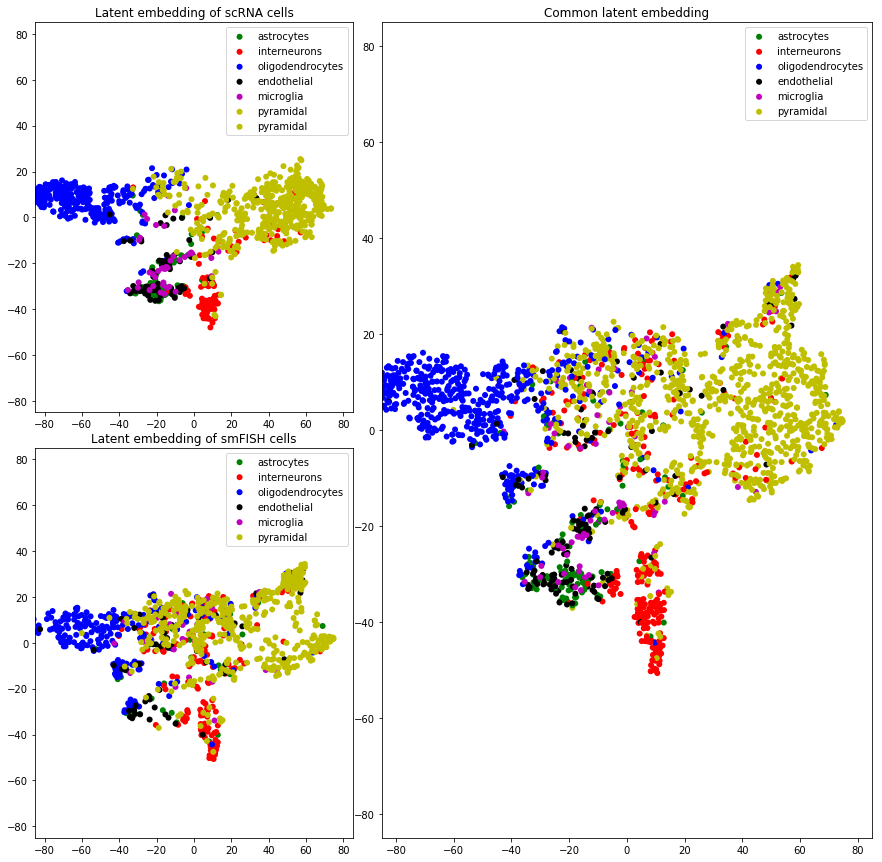

<Figure size 432x288 with 0 Axes>

In [22]:
show_cell_types(t_sne_seq, labels_seq[idx_t_sne_seq], t_sne_fish, labels_fish[idx_t_sne_fish])


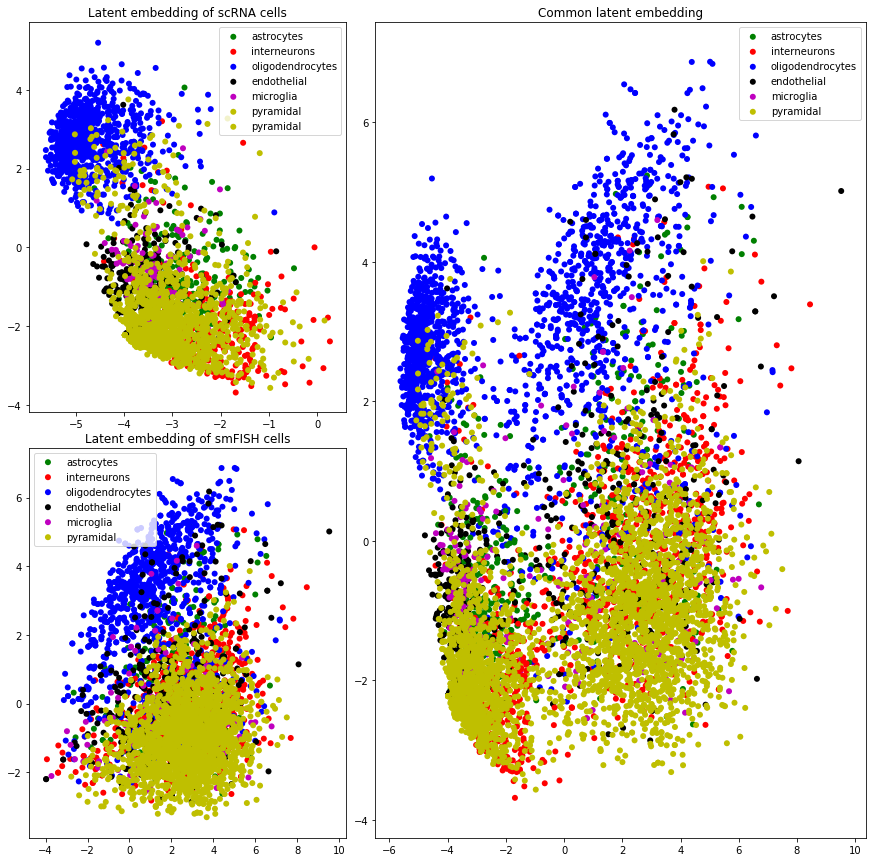

<Figure size 432x288 with 0 Axes>

In [23]:
show_cell_types(PCA_latent_seq[:, :2], PCA_labels_seq.ravel(), PCA_latent_fish[:, :2], PCA_labels_fish.ravel(), x_lim=None)


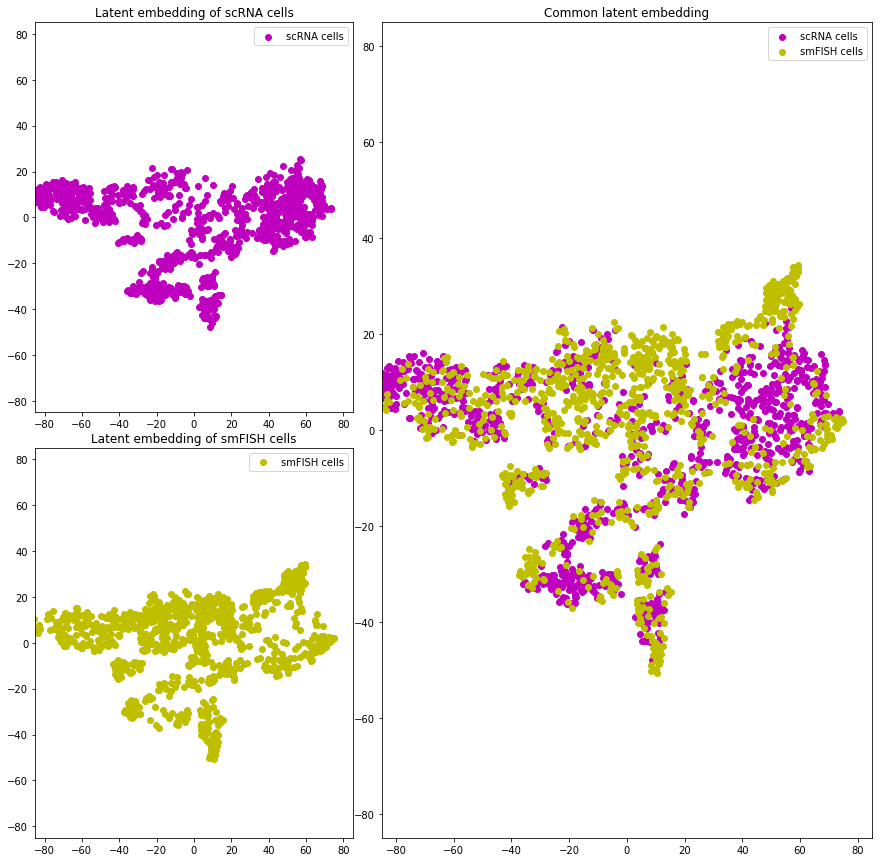

0.6375545170806137


<Figure size 432x288 with 0 Axes>

In [24]:
show_mixing(t_sne_seq, t_sne_fish)
print(entropy_batch_mixing(np.concatenate((t_sne_seq, t_sne_fish)),
                           batches=np.concatenate((np.zeros_like(idx_t_sne_seq),
                                                  np.ones_like(idx_t_sne_fish)))))

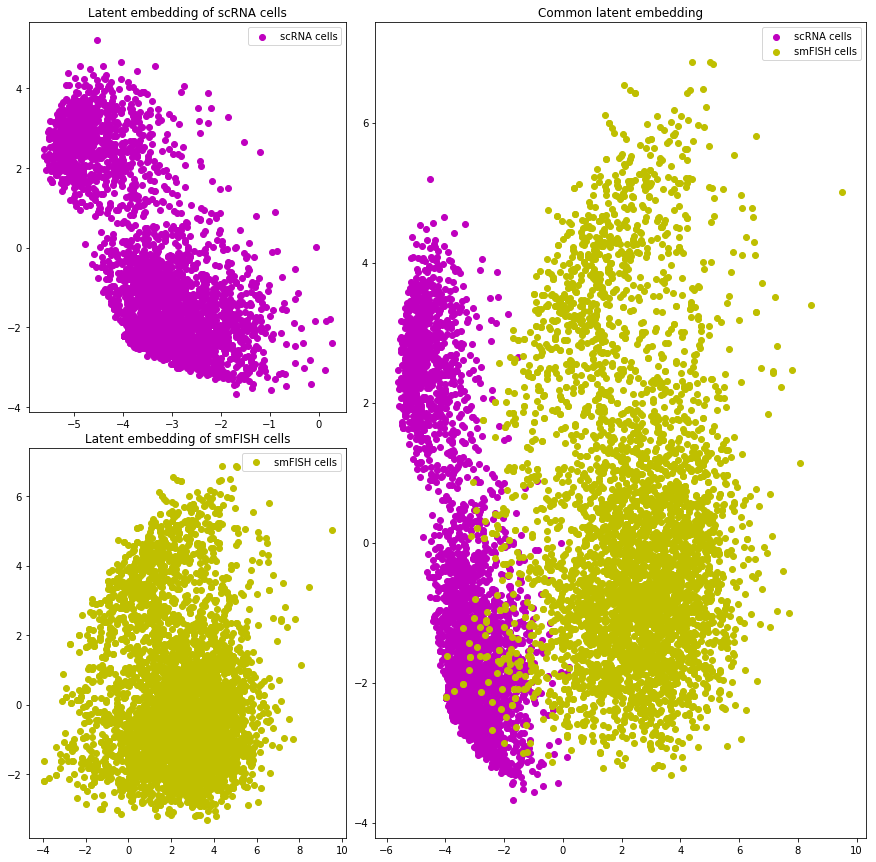

0.10475729275790498


<Figure size 432x288 with 0 Axes>

In [25]:
show_mixing(PCA_latent_seq[:, :2], PCA_latent_fish[:, :2], x_lim=None)
print(entropy_batch_mixing(np.concatenate((PCA_latent_seq[:, :2], PCA_latent_fish[:, :2])),
                           batches=np.concatenate((np.zeros_like(PCA_latent_seq[:, :2]),
                                                  np.ones_like(PCA_latent_fish[:, :2])))))

In [26]:
accuracy, inferred_labels = cluster_accuracy_nn(latent_seq, labels_seq, latent_fish, labels_fish)
PCA_accuracy, PCA_inferred_labels = cluster_accuracy_nn(PCA_latent_seq, PCA_labels_seq.ravel(), PCA_latent_fish, PCA_labels_fish.ravel())


In [27]:
print(accuracy)
print(PCA_accuracy)

61.494396014943966
64.79157328552219


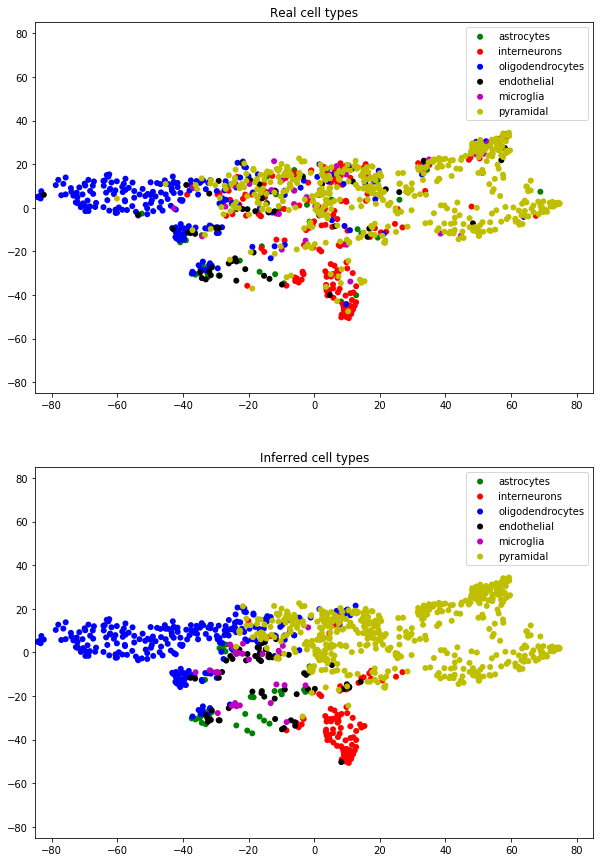

<Figure size 432x288 with 0 Axes>

In [28]:
compare_cell_types(t_sne_fish, labels_fish[idx_t_sne_fish], inferred_labels[idx_t_sne_fish])


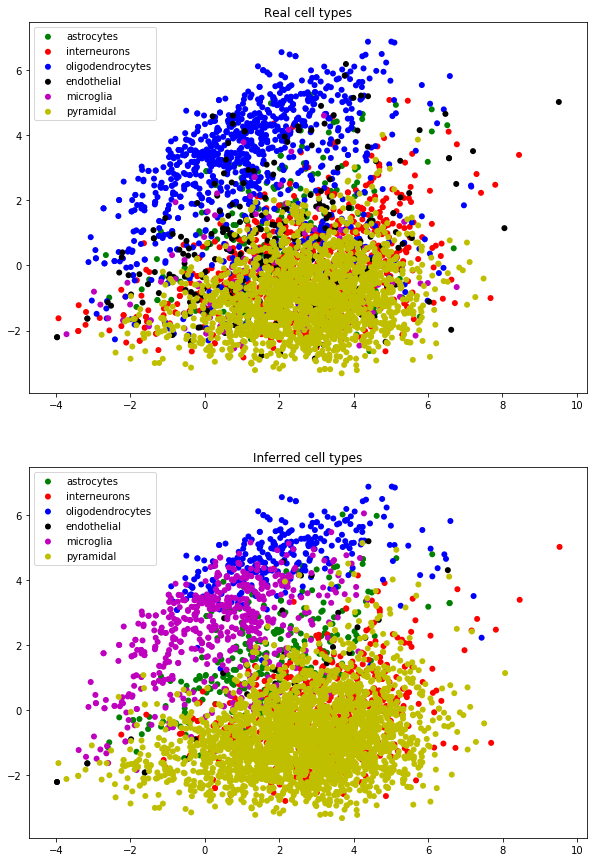

<Figure size 432x288 with 0 Axes>

In [29]:
compare_cell_types(PCA_latent_fish[:, :2], PCA_labels_fish.ravel(), PCA_inferred_labels, x_lim=None)


In [30]:
# Getting more data
normed_expected_frequencies_seq = expected_frequencies_seq / np.sum(expected_frequencies_seq[:, :vae.n_input_fish],
                                                                    axis=1).reshape(-1, 1)
normed_expected_frequencies_fish = expected_frequencies_fish / np.sum(expected_frequencies_fish[:, :vae.n_input_fish],
                                                                    axis=1).reshape(-1, 1)
idx_to_impute = get_index(gene_dataset_seq.gene_names, "gad2")
idx_astro = get_index(gene_dataset_seq.gene_names, "gja1")
idx_oligo = get_index(gene_dataset_seq.gene_names, "mog")
idx_interneurons = get_index(gene_dataset_seq.gene_names, "sst")
proximity_imputed_values_fish = proximity_imputation(latent_seq, normed_expected_frequencies_seq[:, idx_to_impute],
                                                     latent_fish)

real_values_fish = values_fish / np.sum(values_fish, axis=1).reshape(-1, 1)
real_values_fish = real_values_fish[:, 0]

Found idx 35 for gene gad2!
Found idx 98 for gene gja1!
Found idx 82 for gene mog!
Found idx 37 for gene sst!


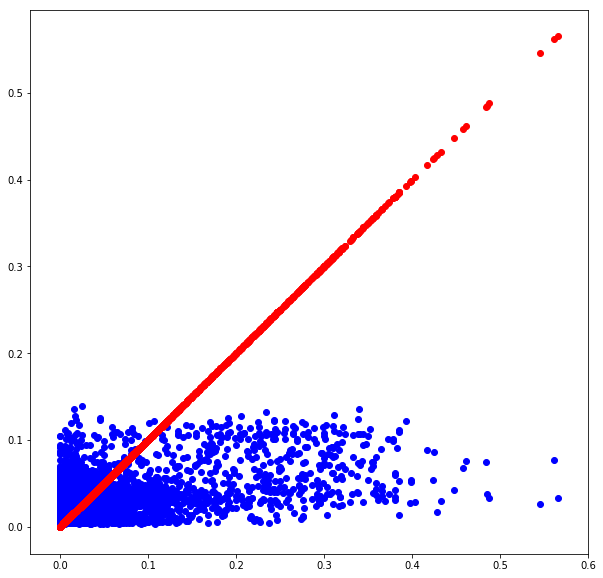

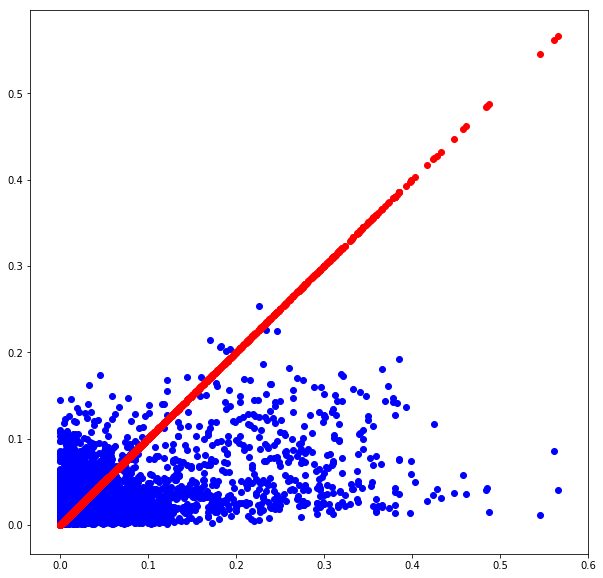

In [31]:
plot_correlation(real_values_fish, proximity_imputed_values_fish)
plot_correlation(real_values_fish, normed_expected_frequencies_fish[:, idx_to_impute])

In [32]:
print(compute_metrics(real_values_fish, proximity_imputed_values_fish))
print(compute_metrics(real_values_fish, normed_expected_frequencies_fish[:, idx_to_impute]))

(0.046287410836060465, 0.025498524332136695, 0.018552919295644427, 0.0027416133153958353)
(0.04596134, 0.024469908, 0.018294238, 0.0025533014)


In [52]:
def is_good(array):
    for value in array:
        if value is True:
            return False
    return True
PCA_latent_fish = PCA_latent_fish.astype(np.float64)
to_keep = [i for i in range(PCA_normed_expected_frequencies_seq.shape[0]) if is_good(np.isnan(PCA_normed_expected_frequencies_seq[i, :])) and is_good(np.isinf(PCA_normed_expected_frequencies_seq[i, :]))]
PCA_normed_expected_frequencies_seq = PCA_values_seq / (np.sum(PCA_values_seq[:, :vae.n_input_fish],
                                                                    axis=1)+PCA_values_seq[:, idx_to_impute]).reshape(-1, 1)
PCA_normed_expected_frequencies_seq = PCA_normed_expected_frequencies_seq.astype(np.float64)
PCA_proximity_imputed_values_fish = proximity_imputation(PCA_latent_seq[to_keep, :], PCA_normed_expected_frequencies_seq[to_keep, idx_to_impute], PCA_latent_fish)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

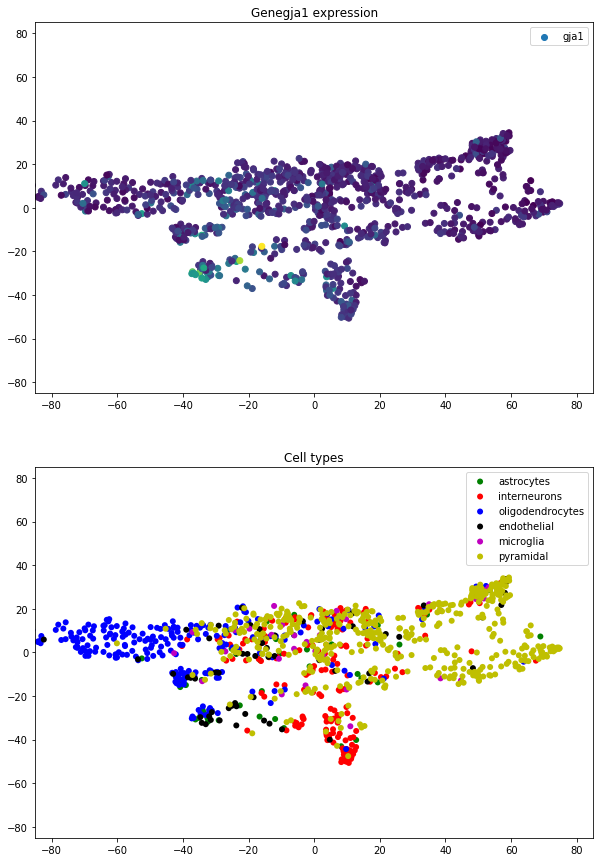

<Figure size 432x288 with 0 Axes>

In [34]:
show_gene_exp(t_sne_fish, normed_expected_frequencies_fish[idx_t_sne_fish, idx_astro], labels=labels_fish[idx_t_sne_fish],
              title="latent_exp_astro.svg", gene_name="gja1")

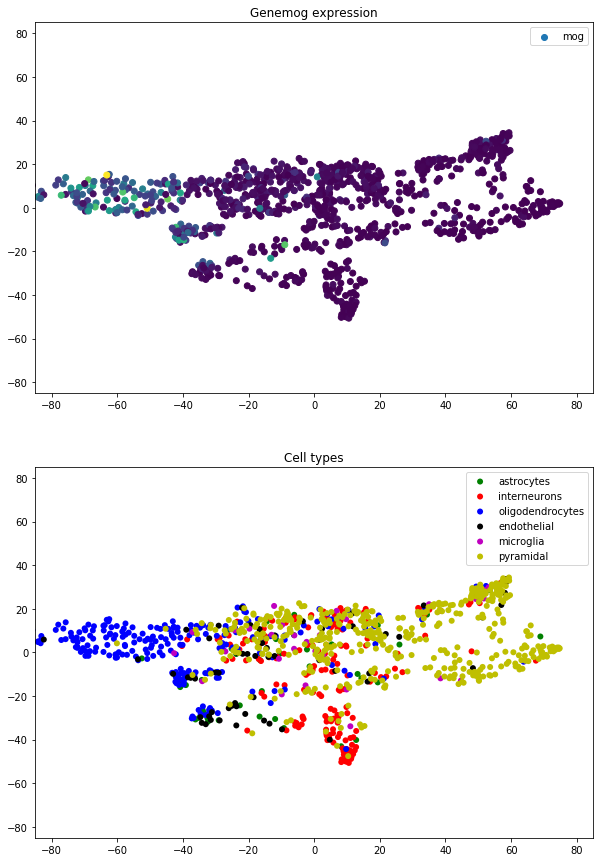

<Figure size 432x288 with 0 Axes>

In [35]:
show_gene_exp(t_sne_fish, normed_expected_frequencies_fish[idx_t_sne_fish, idx_oligo], labels=labels_fish[idx_t_sne_fish],
              title="latent_exp_oligo.svg", gene_name="mog")

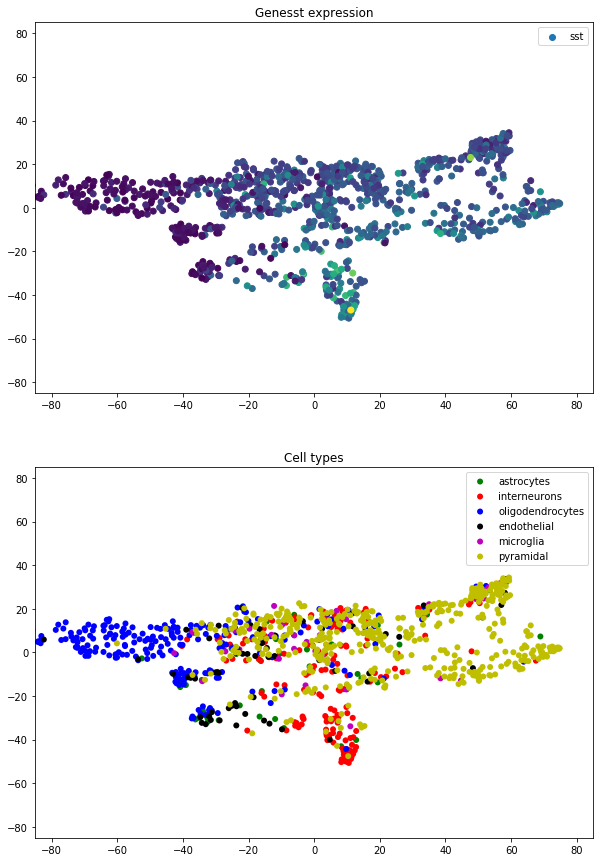

<Figure size 432x288 with 0 Axes>

In [36]:
show_gene_exp(t_sne_fish, normed_expected_frequencies_fish[idx_t_sne_fish, idx_interneurons], labels=labels_fish[idx_t_sne_fish],
              title="latent_exp_interneurons.svg", gene_name="sst")

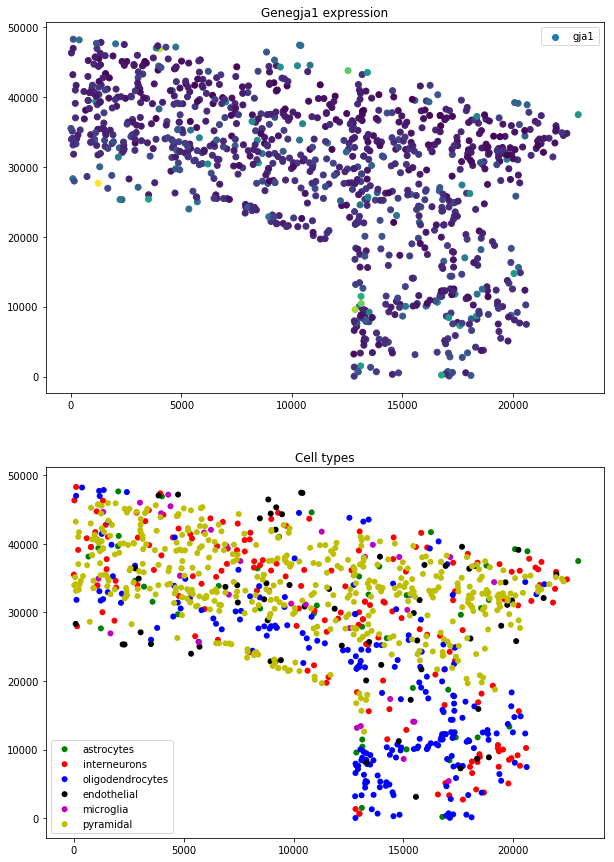

<Figure size 432x288 with 0 Axes>

In [37]:
show_spatial_expression(x_coords[idx_t_sne_fish], y_coords[idx_t_sne_fish],
                        normed_expected_frequencies_fish[idx_t_sne_fish, idx_astro], labels=labels_fish[idx_t_sne_fish],
                        title="spatial_exp_astro.svg", gene_name="gja1")

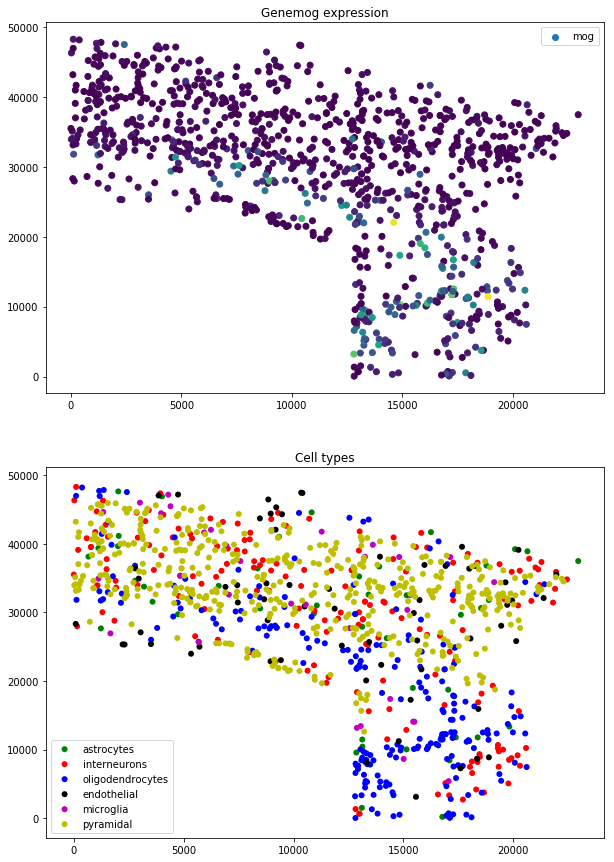

<Figure size 432x288 with 0 Axes>

In [38]:
show_spatial_expression(x_coords[idx_t_sne_fish], y_coords[idx_t_sne_fish],
                        normed_expected_frequencies_fish[idx_t_sne_fish, idx_oligo], labels=labels_fish[idx_t_sne_fish],
                        title="spatial_exp_oligo.svg", gene_name="mog")

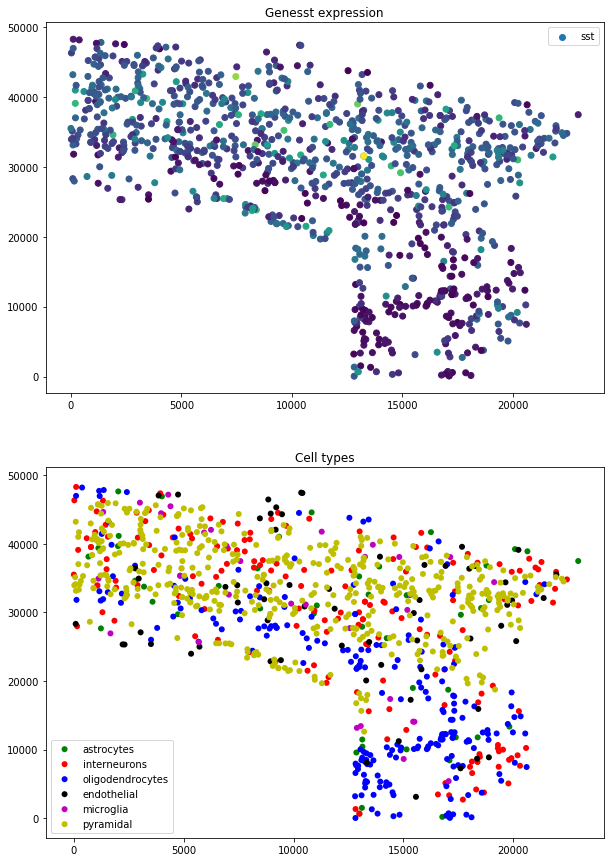

<Figure size 432x288 with 0 Axes>

In [39]:
show_spatial_expression(x_coords[idx_t_sne_fish], y_coords[idx_t_sne_fish],
                        normed_expected_frequencies_fish[idx_t_sne_fish, idx_interneurons],
                        labels=labels_fish[idx_t_sne_fish], title="spatial_exp_interneurons.svg", gene_name="sst")